### Importing libraries:

In [1]:
import pandas as pd
import numpy as np
from PersianStemmer import PersianStemmer
import re
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score

### Reading the dataset:

In [2]:
df = pd.read_csv("updated_bijankhan_corpus.csv")
df: pd.DataFrame

del df['Unnamed: 0']
df.head()

,token,pos_tag,ezafe_tag
0,!هنری!,SUBJ,0
1,#,DELM,0
2,مسعود,N_SING_PR,1
3,شجاعی,N_SING_PR,1
4,طباطبایی,N_SING_PR,0


As you can see, our dataset consists of 3 columns. 'label' column is the one I should predict based on 'part_of_speech' and 'word' columns.

Trying to construct new features and improving the prediction, I **added a few columns** as follows:

In [3]:
st = PersianStemmer()

This function finds the **length of the prefix** of each word in the dataset:

In [4]:
def prefix_length(word):
    stemming = st.run(word)
    if len(stemming) != len(word):
        if word.endswith(stemming) and len(stemming) > 0:
            split = word.split(stemming)
            return len(split[0])
        else:
            return 0
    else:
        return 0

Now I add a new column as follows:

In [5]:
df["prefix_length"] = df['token'].apply(prefix_length)
df.head()

,token,pos_tag,ezafe_tag,prefix_length
0,!هنری!,SUBJ,0,0
1,#,DELM,0,0
2,مسعود,N_SING_PR,1,0
3,شجاعی,N_SING_PR,1,0
4,طباطبایی,N_SING_PR,0,0


Info of newly added column:

In [6]:
df["prefix_length"].value_counts()

0    2602340
1        163
2         33
Name: prefix_length, dtype: int64

Now I add a new column which includes the **length of suffixes** of each word.

In [7]:
def suffix_length(word):
    stemming = st.run(word)
    if len(stemming) != len(word):
        if word.endswith(stemming) and len(stemming) > 0:
            split = word.split(stemming)
            return len(split[1])
        else:
            return 0
    else:
        return 0

In [8]:
df["suffix_length"] = df['token'].apply(suffix_length)
df.head()

,token,pos_tag,ezafe_tag,prefix_length,suffix_length
0,!هنری!,SUBJ,0,0,0
1,#,DELM,0,0,0
2,مسعود,N_SING_PR,1,0,0
3,شجاعی,N_SING_PR,1,0,0
4,طباطبایی,N_SING_PR,0,0,0


Newly added data:

In [9]:
df["prefix_length"].value_counts()

0    2602340
1        163
2         33
Name: prefix_length, dtype: int64

The next feature that, in my opinion, can **help the model** is as follows:

In [10]:
def zamir_find(word):
    suffixes = [ "م", "ت", "ش", "مان", "تان", "شان"]
    stemming = st.run(word)
    if suffix_length(word)>0 and len(stemming)>0:
        suffix = word.split(stemming[1])
        suffix[1].replace(" ", "")
        if suffix[1] in suffixes:
            return 1
    return 0 

In [11]:
df["zamir_find"] = df['token'].apply(zamir_find)
df.head()

,token,pos_tag,ezafe_tag,prefix_length,suffix_length,zamir_find
0,!هنری!,SUBJ,0,0,0,0
1,#,DELM,0,0,0,0
2,مسعود,N_SING_PR,1,0,0,0
3,شجاعی,N_SING_PR,1,0,0,0
4,طباطبایی,N_SING_PR,0,0,0,0


In [12]:
df["zamir_find"].value_counts()

0    2602536
Name: zamir_find, dtype: int64

As you can see **all values of this column are zero**, so that it wouldn't help and I **drop** it.

In [13]:
df.drop('zamir_find', axis=1, inplace=True)
df.head()

,token,pos_tag,ezafe_tag,prefix_length,suffix_length
0,!هنری!,SUBJ,0,0,0
1,#,DELM,0,0,0
2,مسعود,N_SING_PR,1,0,0
3,شجاعی,N_SING_PR,1,0,0
4,طباطبایی,N_SING_PR,0,0,0


Now I find words in **superlative, comparative ,and plural** forms as follows:

In [14]:
def Comparative_Superlative_find(word):
    suffixes = [ "ترین", "تر", "ها"]
    stemming = st.run(word)
    if suffix_length(word)>0 and len(stemming)>0:
        suffix = word.split(stemming[1])
        suffix[1].replace(" ", "")
        if suffix[1] in suffixes:
            return 1
    return 0 

In [15]:
df["c_s_find"] = df['token'].apply(Comparative_Superlative_find)
df.head()

,token,pos_tag,ezafe_tag,prefix_length,suffix_length,c_s_find
0,!هنری!,SUBJ,0,0,0,0
1,#,DELM,0,0,0,0
2,مسعود,N_SING_PR,1,0,0,0
3,شجاعی,N_SING_PR,1,0,0,0
4,طباطبایی,N_SING_PR,0,0,0,0


In [16]:
df["c_s_find"].value_counts()

0    2602536
Name: c_s_find, dtype: int64

All values are zero, so I **drop** this column as well.

In [17]:
df.drop('c_s_find', axis=1, inplace=True)
df.head()

,token,pos_tag,ezafe_tag,prefix_length,suffix_length
0,!هنری!,SUBJ,0,0,0
1,#,DELM,0,0,0
2,مسعود,N_SING_PR,1,0,0
3,شجاعی,N_SING_PR,1,0,0
4,طباطبایی,N_SING_PR,0,0,0


The next feature that may effect the prediction can be the **ending character** of each word.

In [18]:
def end_word(word):
    l = len(word) - 1
    w = "!@#$%^&*()1234567890-=+?/\<>.,;':'"
    for i in range(l, -1, -1):
        if word[i] not in w:
            return word[i]
    return "none"

In [19]:
df["ends_with"] = df['token'].apply(end_word)
df.head()

,token,pos_tag,ezafe_tag,prefix_length,suffix_length,ends_with
0,!هنری!,SUBJ,0,0,0,ی
1,#,DELM,0,0,0,none
2,مسعود,N_SING_PR,1,0,0,د
3,شجاعی,N_SING_PR,1,0,0,ی
4,طباطبایی,N_SING_PR,0,0,0,ی


#### Converting categorical data to numerical:

In [20]:
df["pos_tag"].value_counts()

N_SING_COM         636812
P_GENR             281880
DELM               256489
ADJ_SIM            220353
N_PL_COM           139962
                    ...  
V_AUX_INF_PPF_2         1
V_AUX_INF_NPF_2         1
V_AUX_INF_NPS           1
V_PRS_PCAU_4            1
N_PL_LOC_PAFF_4         1
Name: pos_tag, Length: 482, dtype: int64

Conversion of 'part_of_speech' column:

In [21]:
label_encoder = preprocessing.LabelEncoder()
# Encode labels in column 'part_of_speech'. 
df['pos_tag']= label_encoder.fit_transform(df['pos_tag']) 
df.head()

,token,pos_tag,ezafe_tag,prefix_length,suffix_length,ends_with
0,!هنری!,248,0,0,0,ی
1,#,65,0,0,0,none
2,مسعود,167,1,0,0,د
3,شجاعی,167,1,0,0,ی
4,طباطبایی,167,0,0,0,ی


Conversion of 'ends_with' column:

In [22]:
df["ends_with"].value_counts()

# Encode labels in column 'ends_with'. 
df['ends_with']= label_encoder.fit_transform(df['ends_with']) 
df.head()

,token,pos_tag,ezafe_tag,prefix_length,suffix_length,ends_with
0,!هنری!,248,0,0,0,105
1,#,65,0,0,0,43
2,مسعود,167,1,0,0,72
3,شجاعی,167,1,0,0,105
4,طباطبایی,167,0,0,0,105


In [23]:
df['token']= label_encoder.fit_transform(df['token']) 
df.head()

,token,pos_tag,ezafe_tag,prefix_length,suffix_length,ends_with
0,136,248,0,0,0,105
1,192,65,0,0,0,43
2,53399,167,1,0,0,72
3,39644,167,1,0,0,105
4,42224,167,0,0,0,105


There are **two more features** that I think will help the most.\
The **part of speech of the previous word** and the **part of speech of the next word**.

In [24]:
df["part_pre_1"] = 0
df["part_aft_1"] = 0
df["part_pre_2"] = 0
df["part_aft_2"] = 0
df.head()

,token,pos_tag,ezafe_tag,prefix_length,suffix_length,ends_with,part_pre_1,part_aft_1,part_pre_2,part_aft_2
0,136,248,0,0,0,105,0,0,0,0
1,192,65,0,0,0,43,0,0,0,0
2,53399,167,1,0,0,72,0,0,0,0
3,39644,167,1,0,0,105,0,0,0,0
4,42224,167,0,0,0,105,0,0,0,0


In [25]:
df["part_pre_1"] = df['pos_tag'].shift(periods=1)
df["part_aft_1"] = df['pos_tag'].shift(periods=-1)
df["part_pre_2"] = df['pos_tag'].shift(periods=2)
df["part_aft_2"] = df['pos_tag'].shift(periods=-2)

In [26]:
df.head()

,token,pos_tag,ezafe_tag,prefix_length,suffix_length,ends_with,part_pre_1,part_aft_1,part_pre_2,part_aft_2
0,136,248,0,0,0,105,NaN,65.0,NaN,167.0
1,192,65,0,0,0,43,248.0,167.0,NaN,167.0
2,53399,167,1,0,0,72,65.0,167.0,248.0,167.0
3,39644,167,1,0,0,105,167.0,167.0,65.0,65.0
4,42224,167,0,0,0,105,167.0,65.0,167.0,121.0


In [27]:
df['part_pre_1'] = df['part_pre_1'].fillna(0)
df['part_aft_1'] = df['part_aft_1'].fillna(0)
df['part_pre_2'] = df['part_pre_2'].fillna(0)
df['part_aft_2'] = df['part_aft_2'].fillna(0)

In [28]:
df.head()

,token,pos_tag,ezafe_tag,prefix_length,suffix_length,ends_with,part_pre_1,part_aft_1,part_pre_2,part_aft_2
0,136,248,0,0,0,105,0.0,65.0,0.0,167.0
1,192,65,0,0,0,43,248.0,167.0,0.0,167.0
2,53399,167,1,0,0,72,65.0,167.0,248.0,167.0
3,39644,167,1,0,0,105,167.0,167.0,65.0,65.0
4,42224,167,0,0,0,105,167.0,65.0,167.0,121.0


Now let's have a look at our **data types**:

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2602536 entries, 0 to 2602535
Data columns (total 10 columns):
 #   Column         Dtype  
---  ------         -----  
 0   token          int64  
 1   pos_tag        int64  
 2   ezafe_tag      int64  
 3   prefix_length  int64  
 4   suffix_length  int64  
 5   ends_with      int64  
 6   part_pre_1     float64
 7   part_aft_1     float64
 8   part_pre_2     float64
 9   part_aft_2     float64
dtypes: float64(4), int64(6)
memory usage: 198.6 MB


As you can see 'label' column has **object** data type.\
I need to **fix** this before building our model.\
I do this as bellow:

In [30]:
df["ezafe_tag"] = df["ezafe_tag"].astype(str).astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2602536 entries, 0 to 2602535
Data columns (total 10 columns):
 #   Column         Dtype  
---  ------         -----  
 0   token          int64  
 1   pos_tag        int64  
 2   ezafe_tag      float64
 3   prefix_length  int64  
 4   suffix_length  int64  
 5   ends_with      int64  
 6   part_pre_1     float64
 7   part_aft_1     float64
 8   part_pre_2     float64
 9   part_aft_2     float64
dtypes: float64(5), int64(5)
memory usage: 198.6 MB


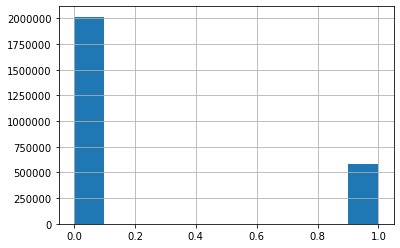

In [33]:
df["ezafe_tag"].hist()

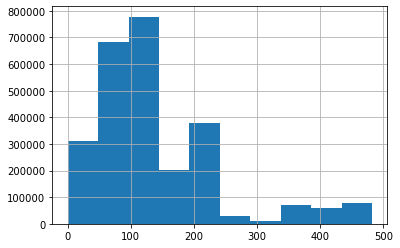

In [34]:
df["pos_tag"].hist()

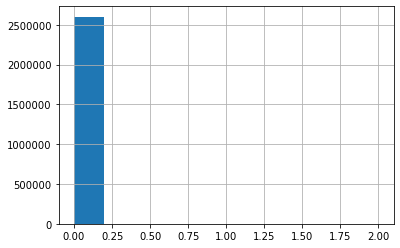

In [35]:
df["prefix_length"].hist()

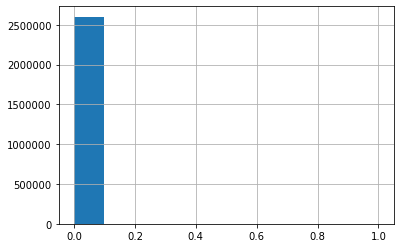

In [36]:
df["suffix_length"].hist()

### Feature selection:

To understand what features I should include in constructing the model, I test **adding and discarding each feature** and finding the acuuary of builded model.
I did feature selection using **GaussianNB** model and after finding usefull features I'll try new models.

In [31]:
df.head()

,token,pos_tag,ezafe_tag,prefix_length,suffix_length,ends_with,part_pre_1,part_aft_1,part_pre_2,part_aft_2
0,136,248,0.0,0,0,105,0.0,65.0,0.0,167.0
1,192,65,0.0,0,0,43,248.0,167.0,0.0,167.0
2,53399,167,1.0,0,0,72,65.0,167.0,248.0,167.0
3,39644,167,1.0,0,0,105,167.0,167.0,65.0,65.0
4,42224,167,0.0,0,0,105,167.0,65.0,167.0,121.0


In [32]:
clf = GaussianNB()

**Testing with the following features:**
* token
* pos_tag
* prefix_length
* suffix_length
* ends_with
* part_aft_1
* part_pre_1

In [33]:
y = df['ezafe_tag']
X=df[["token" ,"pos_tag", "prefix_length", "suffix_length", "ends_with","part_aft_1", "part_pre_1"]]

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

clf.fit(X_train, y_train)

y_predict = clf.predict(X_test)

print(accuracy_score(y_test, y_predict))


0.7457080390695244


**Testing with the following features:**
* token
* pos_tag
* suffix_length
* ends_with
* part_aft_1
* part_pre_1

In [35]:
X=df[["token" ,"pos_tag", "suffix_length", "ends_with","part_aft_1", "part_pre_1"]]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

clf.fit(X_train, y_train)

y_predict = clf.predict(X_test)

print(accuracy_score(y_test, y_predict))


0.7461864178840671


As you can see **discarding 'prefix_length'** ended up in **improving the model**, so I don't use this feature anymore.

**Testing with the following features:**
* token
* pos_tag
* ends_with
* part_aft_1
* part_pre_1

In [36]:
X=df[["token" ,"pos_tag", "ends_with","part_aft_1", "part_pre_1"]]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

clf.fit(X_train, y_train)

y_predict = clf.predict(X_test)

print(accuracy_score(y_test, y_predict))

0.7443363022278235


**Deleting 'suffix_length'** didn't change the accuracy that much.

**Testing with the following features:**
* token
* pos_tag
* part_aft_1
* part_pre_1

In [37]:
X=df[["pos_tag", "ends_with","part_aft_1", "part_pre_1"]]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

clf.fit(X_train, y_train)

y_predict = clf.predict(X_test)

print(accuracy_score(y_test, y_predict))

0.7436677246074989


The **word** ,itself, **shouldn't effect the label** and in my opinion it may cause **overfitting** and our model might **memorize the words** instead of checking the condition the word is in.\
So although deleting word column decrased the accuracy a little, I chosed to **delete this column**. 

**Testing with the following features:**
* pos_tag
* part_aft_1
* part_pre_1

In [38]:
X=df[["pos_tag", "part_aft_1", "part_pre_1"]]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

clf.fit(X_train, y_train)

y_predict = clf.predict(X_test)

print(accuracy_score(y_test, y_predict))

0.7288879325581932


As you can see **'ends_with'** column is **usefull**.

**Testing with the following features:**
* pos_tag
* part_aft_1
* ends_with

In [39]:
X=df[["pos_tag", "part_aft_1", "ends_with"]]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

clf.fit(X_train, y_train)

y_predict = clf.predict(X_test)

print(accuracy_score(y_test, y_predict))

0.7377043196262113


**Deleting 'part_pre_1'** which shows the part of speech of the previous word **improves the model**.

**Testing with the following features:**
* pos_tag
* part_pre_1
* ends_with

In [40]:
X=df[["pos_tag", "part_pre_1", "ends_with"]]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

clf.fit(X_train, y_train)

y_predict = clf.predict(X_test)

print(accuracy_score(y_test, y_predict))

0.7353143467535561


**Testing with the following features:**
* token
* pos_tag
* part_aft_1

In [41]:
X=df[["token","pos_tag", "part_aft_1"]]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

clf.fit(X_train, y_train)

y_predict = clf.predict(X_test)

print(accuracy_score(y_test, y_predict))

0.7942337101447048


**Testing with the following features:**
* token
* pos_tag
* part_aft_1
* part_aft_2
* part_pre_1
* ends_with

In [42]:
X=df[["token","pos_tag", "part_aft_1", "part_aft_2", "part_pre_1", "ends_with"]]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

clf.fit(X_train, y_train)

y_predict = clf.predict(X_test)

print(accuracy_score(y_test, y_predict))

0.7492603379775142


#### Deciding which features to use:
The best accuracy I got was the one with the feature **'token', 'pos_tag'** and **'part_aft_1'**.
So from now on I use these features and try different models(othe than GaussianNB) to find the best fit for this dataset.

#### Model selection:

In [43]:
def ac_pr_re(Y_test, Y_predict):
    accuracy = accuracy_score(Y_test, y_predict)
    percision = precision_score(Y_test, y_predict)
    recall = recall_score(Y_test, y_predict, average="binary")
    
    print("accuracy :", end=" ")
    print(float(accuracy)*100)
    
    print("percision :", end=" ")
    print(float(percision)*100)
    
    print("recall :", end=" ")
    print(float(recall)*100)

**MultinomialNB:**

In [56]:
X = list(zip(df["token"], df["pos_tag"], df["part_aft_1"], df["part_aft_2"], df["part_pre_1"], df["ends_with"]))
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)
X_train = X[:-100000]
X_test = X[-100000:]
y_train = y[:-100000]
y_test = y[-100000:]

In [57]:
clf = MultinomialNB()

clf.fit(X_train, y_train)

y_predict = clf.predict(X_test)

ac_pr_re(y_test, y_predict)

accuracy : 62.781
percision : 34.853983896166326
recall : 58.908839779005525


**DecisionTree:**

In [58]:
clf = tree.DecisionTreeClassifier()

clf.fit(X_train, y_train)

y_predict = clf.predict(X_test)

print(ac_pr_re(y_test, y_predict))

accuracy : 96.788
percision : 93.86065573770492
recall : 93.03704907377316
None


**Perceptron classifier:**

In [59]:
clf = Perceptron(tol=1e-3,n_iter_no_change=8, random_state=0)

clf.fit(X_train, y_train)

y_predict = clf.predict(X_test)

ac_pr_re(y_test, y_predict)

accuracy : 60.916000000000004
percision : 37.709819911654776
recall : 90.16899577510561


**Logistic Regression:**

In [60]:
clf = LogisticRegression(random_state=0)

clf.fit(X_train, y_train)

y_predict = clf.predict(X_test)

ac_pr_re(y_test, y_predict)

/home/niloufar/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy : 74.786
percision : 45.557206537890046
recall : 12.45531361715957


**MLP (neural network):**

In [61]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(3, 2), random_state=1)

clf.fit(X_train, y_train)

y_predict = clf.predict(X_test)

ac_pr_re(y_test, y_predict)

/home/niloufar/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/niloufar/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy : 75.384
percision : 0.0
recall : 0.0
